# Prediction Pipeline

## Load model architecture
Architecture must be identical to the one used to create the weights. However, you can fix the trained layers and add new layers to accommodate new problems; see https://www.biorxiv.org/content/10.1101/2021.06.26.449864v1.full

In [ ]:
! mamba install -y -c plotly plotly

In [18]:
from keras.models import load_model
model=load_model('data/model/gtex/manual/gtex_model.h5')
print("Saved model summary:")
model.summary()

Saved model summary:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 1000)              18964000  
_________________________________________________________________
1_decoder_batch_norm (BatchN (None, 1000)              4000      
_________________________________________________________________
1_activation (Activation)    (None, 1000)              0         
_________________________________________________________________
1_hidden_dropout (Dropout)   (None, 1000)              0         
_________________________________________________________________
output (Dense)               (None, 26)                26026     
Total params: 18,994,026
Trainable params: 18,992,026
Non-trainable params: 2,000
_________________________________________________________________


In [19]:
#load weights from last best checkpoint
model.load_weights("data/model/gtex")

2022-07-21 13:05:54.203216: W tensorflow/core/util/tensor_slice_reader.cc:95] Could not open data/model/gtex: Failed precondition: data/model/gtex; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


# Load and set up data
Make predictions on all the original, unshuffled training data to see which IDs are incorrectly predicted. 

In [20]:
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
expr_df = pd.read_feather("data/gtex/expr.ftr")
attr_df = pd.read_table('dist/gtex/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt')
label_df=attr_df[['SAMPID','SMTS']].merge(expr_df, how='inner', left_on='SAMPID', right_on='sample_id')
labels = [s for s in label_df.SMTS.unique() if s not in ['Bone Marrow', 'Fallopian Tube', 'Cervix Uteri', 'Bladder','Skin']]
SAMPLE_COUNT_THRESHOLD=100
TRAINING_REINITIALIZATIONS=5
counts={}
print(f"Drop under-represented classes with less than {SAMPLE_COUNT_THRESHOLD} samples:")
for label in label_df.SMTS.unique():
    count = label_df[(label_df.SMTS==label)].shape[0]
    # if count < 200 or label == "Heart" or label == "Lung" or label == "Brain":
    if count < SAMPLE_COUNT_THRESHOLD:
        label_df = label_df[label_df.SMTS!=label]
        print(f"dropped {label}")
    else:
        counts[label]=count
print("Counts per 'super-class':")
#class_names=np.array(list(counts.keys()))
print(f"(total number of samples, total number of genes) = \n{label_df.shape}")
for idx, (label, count) in enumerate(counts.items()):
    print(f"[{idx:2}] {label:12}\t{count:4} samples")
labels=list(label_df.SMTS.unique())
#labels
X=label_df.drop(['SMTS','SAMPID','sample_id'],axis=1)
X=np.log2(np.array(X)+1)
X=X/X.max()
le = LabelEncoder()
y = tf.one_hot(le.fit_transform(list(label_df['SMTS'])), len(labels))
#given an index, class_names will tell you the tissue type
# labels order is not retained in the labeleoncoder, so reset the order in class_names for use later:
class_names = le.classes_

Drop under-represented classes with less than 100 samples:
dropped Kidney
dropped Cervix Uteri
dropped Fallopian Tube
dropped Bladder
Counts per 'super-class':
(total number of samples, total number of genes) = 
(17244, 18966)
[ 0] Adipose Tissue	1204 samples
[ 1] Muscle      	 803 samples
[ 2] Blood Vessel	1335 samples
[ 3] Heart       	 861 samples
[ 4] Uterus      	 142 samples
[ 5] Vagina      	 156 samples
[ 6] Breast      	 459 samples
[ 7] Skin        	1809 samples
[ 8] Salivary Gland	 162 samples
[ 9] Brain       	2642 samples
[10] Adrenal Gland	 258 samples
[11] Thyroid     	 653 samples
[12] Lung        	 578 samples
[13] Spleen      	 241 samples
[14] Pancreas    	 328 samples
[15] Esophagus   	1445 samples
[16] Stomach     	 359 samples
[17] Colon       	 779 samples
[18] Small Intestine	 187 samples
[19] Prostate    	 245 samples
[20] Testis      	 361 samples
[21] Nerve       	 619 samples
[22] Blood       	 929 samples
[23] Pituitary   	 283 samples
[24] Ovary       	 18

In [21]:
X.shape,y.shape

((17244, 18963), TensorShape([17244, 26]))

# Predict and assess mislabeled data

In [30]:
# break up the dataset, there's too many to predict at once
y_pred_1 = model.predict(X[:9000])

In [23]:
pred_df = pd.DataFrame(class_names[np.argmax(y_pred_1,axis=1)], columns=["predicted"])
obs_df = pd.DataFrame(class_names[np.argmax(y[:9000],axis=1)], columns=["observed"])
pred_obs_df = pd.concat([label_df.reset_index()[:9000]['sample_id'], pred_df, obs_df], axis=1)
mis_predicted = pred_obs_df[pred_obs_df["observed"]!=pred_obs_df['predicted']].sort_values(by='observed')
mis_predicted.groupby(['observed','predicted']).count().sort_values(by='observed')

sample_id
observed        predicted                 
Adipose Tissue  Blood Vessel             2
                Breast                   3
Blood Vessel    Adipose Tissue           4
                Heart                    2
                Skin                     1
Breast          Adipose Tissue          21
                Salivary Gland           1
Colon           Adipose Tissue           1
                Small Intestine          5
Esophagus       Nerve                    1
                Colon                    1
                Salivary Gland           1
                Adipose Tissue           2
                Blood Vessel             3
Heart           Blood Vessel             1
Ovary           Uterus                   2
Prostate        Esophagus                1
                Nerve                    1
Salivary Gland  Esophagus                4
                Vagina                   1
Skin            Adipose Tissue           1
Small Intestine Adipose Tissue           1
                Colon                    2
Stomach         Esophagus                1
Uterus          Ovary                    1
                Blood Vessel             1
Vagina          Uterus                   1

# Plot two classes with a single mislabel
The "Heart" class had 1 incorrect prediction of 861 samples. A "Blood Vessel" sample was incorrectly labeled as "Heart". To gain insight around the mislabel, plot the Heart principal components against Blood Vessel principal components and annotate the mislabeled sample.

In [24]:
idx = mis_predicted[mis_predicted['observed']=="Heart"]["sample_id"]
idx

6065    GTEX-17HII-1326-SM-7IGOB
Name: sample_id, dtype: object

In [25]:
import gzip
import numpy as np
import pandas as pd
import os
import pathlib
from sklearn.decomposition import PCA

CLASS_NAMES=["Heart","Blood Vessel"]
USE_PYPLOT=True
NUM_PCS=3
MAX_SAMPS=200000

# read data
def read_from_raw():
    attr_path = 'dist/gtex/GTEx_Analysis_v8_Annotations_SampleAttributesDS.txt'
    attr_df = pd.read_table(attr_path)

    expr_df = pd.read_feather("data/gtex/expr.ftr")
    expr_df.reset_index(drop=True)
    expr_df=expr_df.set_index('sample_id')
    expr_df.index.name="SAMPID"
    expr_df.reset_index(inplace=True)

    expr_df=pd.merge(expr_df,attr_df[["SAMPID","SMTS"]])

    expr_df=expr_df.set_index('SAMPID')
    cols = expr_df.columns
    cols =cols[-1:].append(cols[:-1])
    expr_df=expr_df[cols]
    expr_df =expr_df[(expr_df['SMTS']==CLASS_NAMES[0]) | (expr_df['SMTS']==CLASS_NAMES[1])]

    return expr_df

df=read_from_raw()

# compute PCs
pca = PCA()
components = pca.fit_transform(df.iloc[:,1:])
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}
pc1,pc2,pc3 = components[df.reset_index()[df.reset_index()['SAMPID'] ==  list(idx)[0]].index][0][0:3]


# Visualize the mislabeled point with PCA
Every dot on the PC1,PC2,PC3 plot below was correctly labeled with only one exception. Notice the points that are correctly predicted, despite clustering together with the incorrect class, per PCA. This is likely explained by PCA's difficulty with discerning non-linear relationships, with which neural nets excel.

In [28]:
from plotly.offline import init_notebook_mode
init_notebook_mode(connected = True)

import plotly.express as px
import plotly.graph_objects as go
var = pca.explained_variance_ratio_.sum()
fig = go.Figure()
fig = px.scatter_3d(components, x=0, y=1, z=2, color=df['SMTS'],
                    title=f'Total Explained Variance: {var}',
                    labels={'0':'PC1', '1':'PC2', '2':'PC3'}
                   )
fig.update_layout(
    scene=dict(
        xaxis=dict(type="linear"),
        yaxis=dict(type="linear"),
        zaxis=dict(type="linear"),
        annotations=[
        dict(
            showarrow=True,
            x=pc1,
            y=pc2,
            z=pc3,
            text="Mislabeled as Blood Vessel",
            xanchor="left",
            xshift=0,
            opacity=0.7)
         ]
    ),
)
'''
temp1 = fig.data[0].hovertemplate
fig.update_traces(hovertemplate = temp1 + '<br>' + "Category: %{customdata[0]}")

fig.add_annotation(x=pc1, y=pc2, z=pc3,
            text="Mislabeled as Blood Vessel",
            showarrow=True,
            arrowhead=1)
'''
fig.update_traces( marker={'size':2})
fig.show()

# 3D PCA scatter plot
An interactive plot should appear as follows:
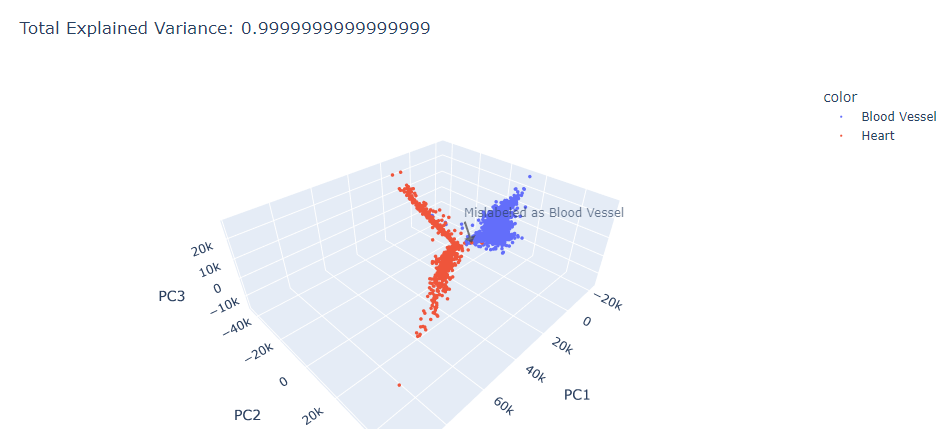